<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

<center> <img src=https://i.imgur.com/0TSSaqL.png width="550"> </center>

<center>
    <h3><b>Módulo 5 - Unidad 4<br/>Deep Learning</b></h3>
    <h4><b>Caso Práctico - Adriana Vargas</b></h4>
</center>

# Caso práctico

Se seleccionaron imágenes de rayos X de tórax (anterior-posterior) de cohortes retrospectivas de pacientes pediátricos de uno a cinco años del Centro Médico de Mujeres y Niños de Guangzhou, Guangzhou. Todas las imágenes de rayos X de tórax se realizaron como parte de la atención clínica de rutina de los pacientes.

Para el análisis de las imágenes de rayos X de tórax, todas las radiografías de tórax se revisaron inicialmente para el control de calidad mediante la eliminación de todos los escaneos de baja calidad o ilegibles. Luego, dos médicos expertos calificaron los diagnósticos de las imágenes antes de autorizarlos para entrenar el sistema de IA. Para tener en cuenta cualquier error de calificación, el conjunto de evaluación también fue verificado por un tercer experto.

En este ejercicio, buscamos desarrollar una red neuronal para procesar las imágenes médicas que proporcione un diagnóstico lo más preciso posible de la patología y pongas en práctica lo aprendido. 

Ten en cuenta:

Debes mantener la estructura de las carpetas de train, test y val con los mismos ficheros incluido en cada carpeta.

# Exploración del dataset

Para la solución de este caso práctico, vamos a trabajar con las redes neuronales convolucionales (CNN), dado que se trata de un caso de predicción basado en imágenes, así el ordenador procesa una imagen de una forma similar a como lo hace nuestro cerebro, identificando distintas características en las entradas que hacen que se puedan identificar los objetos.

Los pasos de la convolución que vamos a aplicar, son los siguientes:

1. Vamos a ajustar la CNN a las imágenes de entrenamiento
2. Construir el modelo de CNN
3. Compilar y entrenar la CNN
4. Validar el modelo
5. Hacer nuevas predicciones

Primero, importamos todas las librerías que vamos a necesitar.

In [79]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.metrics import Precision, Recall
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

A nivel del dataset original, tenemos 3 folders, `train`, `test` y `val`.

En el folder `val` tenemos solo 16 imágenes que usaremos como validación para la predicción final.

In [3]:
base_dir = 'chest_xray/'

os.listdir(base_dir)

['.DS_Store', 'test', 'train', 'val']

En cada folder tenemos 2 subfolders `NORMAL` y `PNEUMONIA` que corresponden a imágene de pulmones normales, o de pulmones con pneumonía.

Vamos a revisar el número de imágenes que tenemos en los diferentes subfolders:


In [4]:
train_normal_dir = base_dir + 'train/NORMAL'
train_pneumonia_dir = base_dir + 'train/PNEUMONIA'

test_normal_dir = base_dir + 'test/NORMAL'
test_pneumonia_dir = base_dir + 'test/PNEUMONIA'

val_normal_dir = base_dir + 'val/NORMAL'
val_pneumonia_dir = base_dir + 'val/PNEUMONIA'

print('Total train NORMAL images:', len(os.listdir(train_normal_dir)))
print('Total train PNEUMONIA images:', len(os.listdir(train_pneumonia_dir)))

print('Total test NORMAL images:', len(os.listdir(test_normal_dir)))
print('Total test PNEUMONIA images:', len(os.listdir(test_pneumonia_dir)))

print('Total val NORMAL images:', len(os.listdir(val_normal_dir)))
print('Total val PNEUMONIA images:', len(os.listdir(val_pneumonia_dir)))

Total train NORMAL images: 1341
Total train PNEUMONIA images: 3875
Total test NORMAL images: 234
Total test PNEUMONIA images: 390
Total val NORMAL images: 8
Total val PNEUMONIA images: 8


Ahora vamos a explorar las imágenes que tenemos en el folder `train` para NORMAL y PNEUMONIA, y a crear un dataset para ver más fácilmente la proporción:

In [5]:
# We create a dataframe with all the normal images and label 0 (no pneumonia)
# and all the pneumonia images with label 1
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in os.listdir(train_normal_dir):
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in os.listdir(train_pneumonia_dir):
    train_data.append((img, 1))

# We create the dataframe with the list of images and label of sickness
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
train_df.head()


,image,label
0,NORMAL2-IM-0927-0001.jpeg,0
1,NORMAL2-IM-1056-0001.jpeg,0
2,IM-0427-0001.jpeg,0
3,NORMAL2-IM-1260-0001.jpeg,0
4,IM-0656-0001-0001.jpeg,0


In [6]:
train_df['label'].value_counts()

1    3875
0    1341
Name: label, dtype: int64

In [7]:
train_df["label"].value_counts(normalize = True)

1    0.742906
0    0.257094
Name: label, dtype: float64

Como podemos observar el dataset está desbalanceado, con un 74,29% de imágenes con Neumonía, vs un 25,71% de imágenes de casos sanos.

Cuando estemos en la fase de "compilar y entrenar el modelo", aplicaremos pesos a cada clase particular de acuerdo al número de imágenes para compensar el desbalance. 

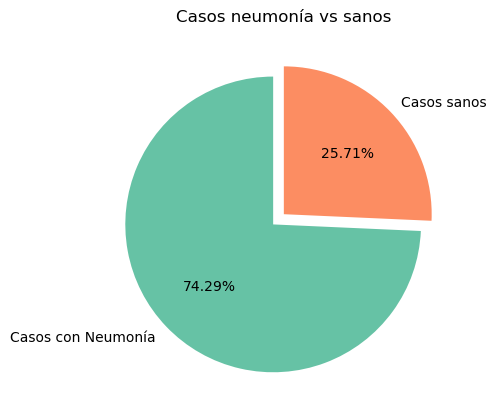

In [8]:
# Define data
vf = train_df["label"].value_counts(normalize = True)
data = [ vf[1], vf[0]]
explode = (0.1, 0)

# Create pie chart
labels = ["Casos con Neumonía","Casos sanos"]
plt.pie(data, labels = labels, autopct='%.2f%%', startangle=90,
        explode=explode, colors=sns.color_palette('Set2'))
plt.title("Casos neumonía vs sanos")
plt.show()

Ahora vamos a explorar algunas de las imágenes contenidas en el dataset:

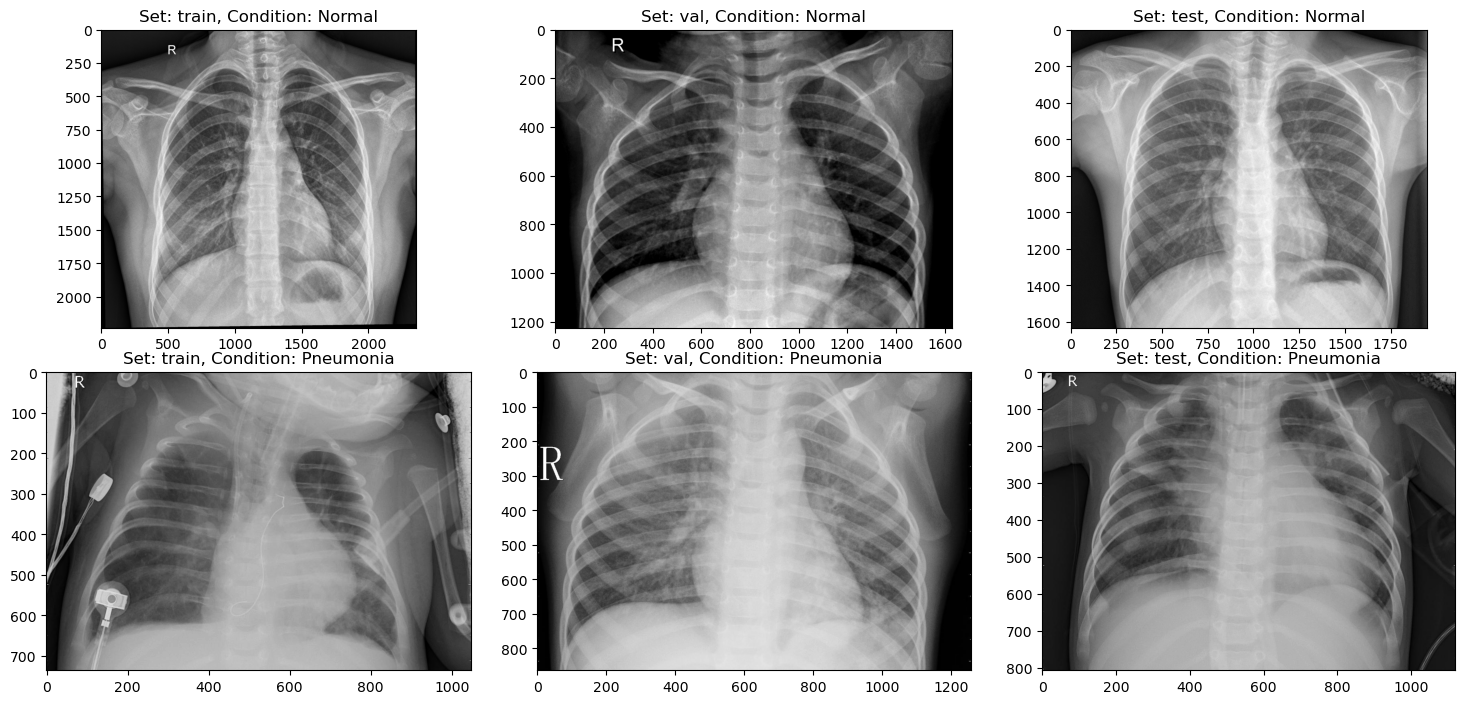

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = base_dir + _set
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

A simple vista es muy difícil notar la diferencia, solo el expertise de los médicos lo puede hacer, pero una buena de predicción en casos médicos ayuda en gran medida a automatizar y tener una segunda fuente de análisis.

# Ajustar la CNN a las imágenes para entrenar

Ahora vamos a procesar las imágenes con la clase `ImageDataGenerator` de keras, módulo `preprocessing.image`, para evitar el overfitting.

Vamos a usar un generador para las imágenes del dataset de `training` y otro para las imágenes del dataset de `test`.

Los generadores que vamos a definir trabajarán en batches de **64** imágenes, de tamaño **150x150**.
Las imágenes serán procesadas para ser normalizadas a valores de píxeles en el rango de 0 a 1, también se realizará data augmentation para el dataset de training rotando la imagen y también aplicando cierta cantidad de zoom.

In [10]:
# All images will be rescaled by 1.0/255
train_datagen = ImageDataGenerator(
      rescale = 1./255, # escaled to get values between 0 and 1
      shear_range = 0.2, # 20% rotation angle 
      zoom_range = 0.2, # data augmentation in 20%, with interval (0.8,1.2)
      rotation_range = 20,
      horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255)

train_dataset = train_datagen.flow_from_directory(base_dir + '/train',
  target_size = (150, 150),
  batch_size = 64,
  class_mode = 'binary')

test_dataset = test_datagen.flow_from_directory(base_dir + '/test',
  target_size = (150, 150),
  batch_size = 64,
  class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Construir el modelo de CNN

Después de tener cargadas las imágenes, creamos las convoluciones y la red.

Primero la inicializamos con `Sequential`, para que nos cree los pesos de forma aleatoria.

Creamos las diferentes capas de convolución con `Conv2D` y los siguientes argumentos:

- **filters**: número de filtros (**mapa de características**) a extraer, está estudiado que los **múltiplos de 2** funcionan bien en las convoluciones y es aconsejable **no comenzar con valores muy altos**, 32 es lo normal (2^5).
- **kernel_size**: es el **tamaño** del filtro que vamos a aplicar, siempre **cuadrado**.
- **input_shape**: es el **tamaño** de las fotos de **entrada** (también **múltiplos de 2** hace **converger** mejor a la red) y si es **en color o no**, va dentro de una tupla.
- **activation**: **función de activación**, RELU es la más utilizada en imágenes, recordar que es la que convierte los valores negativos a 0 y elimina la linealidad.

Para cada una de las convoluciones definidas, vamos aumentando el número de filters, el **mapa de características** a extraer.

El siguiente paso es aplicar Batch normalization con `BatchNormalization` para hacer el entrenamiento de la red más rápido y más estable a través de la normalización de capas.

Por último, en la construcción inicial del modelo, aplicamos la reducción de dimensión con `MaxPooling2D`, para ello aplicaremos el pooling como el máximo (max-pooling) con una matriz de 2x2. Cuanto más reduzcamos más información perderemos, si aplicamos 3x3 reduciremos más los datos y se perderá más información.

In [11]:
classifier = Sequential()

# The first convolution
classifier.add(Conv2D(filters = 32, # number of filters, 2^5
    kernel_size = (3,3),            # filter size
    input_shape = (150, 150, 3),     # image size
    activation = 'relu')
)
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
               
# The second convolution    
classifier.add(Conv2D(filters = 64, # number of filters
    kernel_size = (3,3),            # filter size
    activation = 'relu')
)
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The third convolution
classifier.add(Conv2D(filters = 128, # nunmber of filters
    kernel_size = (3,3),            # filter size
    activation = 'relu')
)
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
               
# The fourth convolution
classifier.add(Conv2D(filters = 256, # nunmber of filters
    kernel_size = (3,3),            # filter size
    activation = 'relu')
)
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))

Después de la fase de convolución tenemos que preparar la entrada a la red neuronal, para ello aplanamos la matriz en un tensor de una dimensión, esto lo llevamos a cabo con `Flatten`.

Aplicaremos también `Dropout` para aleatoriamente apagar neuronas y así ayudar a controlar el **overfitting**, normalmente se parametriza a 0.5.

In [12]:
# Flatten the results to feed into a DNN
classifier.add(Flatten())
classifier.add(Dropout(0.5))

Una vez aplanado generamos la red con el método **Dense**.

Hay que decirle cuántas neuronas queremos incluir en la capa oculta y la función de activación RELU. Si es necesario podemos ir incrementando las capas ocultas antes de incluir la capa de salida. En nuestro caso como tenemos dos categorías podemos usar una **función de activación sigmoide** con un nodo (sólo un nodo porque nos devolverá la probabilidad de detectar neumonía o no), en caso de tener **más de dos categorías** tendríamos que usar **softmax**.

In [13]:
classifier.add(Dense(units = 128, activation = "relu"))
classifier.add(Dense(units = 1, activation = "sigmoid"))

In [14]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

# Compilar y entrenar la CNN

En esta fase vamos a compilar y entrenar la red, usaremos los parámetros:

- **optimizer:** RMSprop, es un algoritmo descenso de gradiente estocástico similar a Adam.
- **loss:** binary_crossentropy, al tener dos categorías.
- **metrisc**: accuracy, precision y recall.

In [15]:
metrics = ['accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

classifier.compile(optimizer = "RMSprop",
  loss = "binary_crossentropy",
  metrics = metrics)

Como vimos en la fase de exploración del dataset, para tratar el desbalance vamos a asignar pesos a cada clase.

In [16]:
train_normal_count = len(os.listdir(train_normal_dir))
train_pneumonia_count = len(os.listdir(train_pneumonia_dir))
total_train_count = train_normal_count + train_pneumonia_count

test_normal_count = len(os.listdir(test_normal_dir))
test_pneumonia_count = len(os.listdir(test_pneumonia_dir))
total_test_count = test_normal_count + test_pneumonia_count

weight_for_normal_0 = (1 / train_normal_count)*(total_train_count)/2.0 
weight_for_pneumonia_1 = (1 / train_pneumonia_count)*(total_train_count)/2.0

class_weight = {0: weight_for_normal_0, 1: weight_for_pneumonia_1}

print(class_weight)

{0: 1.9448173005219984, 1: 0.6730322580645162}


En la fase de entrenamiento hay que tener en cuenta que estamos usando un **batch_size** (el número de observaciones a usar para procesar los pesos), por lo que a la hora de definir el número de pasos por **epoch**, como máximo ha de ser el número de observaciones en el dataset dividido por el batch size.


In [17]:
# Reduce learning rate when a metric has stopped improving
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_recall',
    patience = 3,
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000001)

# Stop training when a monitored metric has stopped improving
early_stop = EarlyStopping(patience = 10,
    restore_best_weights = True,
    verbose = 1)

# Train the model
history = classifier.fit(train_dataset,
    epochs = 30,
    steps_per_epoch = total_train_count // 64,
    validation_data = test_dataset,
    validation_steps = total_test_count // 64,
    class_weight = class_weight,
    callbacks = [learning_rate_reduction, early_stop]
)

Epoch 1/30


2023-07-11 21:10:09.830883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/81 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.8424 - precision: 0.9456 - recall: 0.8359

2023-07-11 21:11:16.492408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


81/81 [==============================] - 71s 855ms/step - loss: 0.6104 - accuracy: 0.8424 - precision: 0.9456 - recall: 0.8359 - val_loss: 9.9388 - val_accuracy: 0.6267 - val_precision: 0.6267 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/30
81/81 [==============================] - 70s 851ms/step - loss: 0.3060 - accuracy: 0.8789 - precision: 0.9638 - recall: 0.8697 - val_loss: 26.2233 - val_accuracy: 0.6215 - val_precision: 0.6215 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/30
81/81 [==============================] - 69s 844ms/step - loss: 0.2605 - accuracy: 0.9024 - precision: 0.9711 - recall: 0.8952 - val_loss: 36.8174 - val_accuracy: 0.6267 - val_precision: 0.6267 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/30
81/81 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9158 - precision: 0.9717 - recall: 0.9134
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
81/81 [==============================] - 70s 850ms/step - loss: 0.2166 - accuracy: 0.91

# Validar el modelo

Con nuestra red conseguimos un accuracy en promedio en el data de training de 94.37% y en el data de test de 77.26%, para ello hemos usado cuatro capas convolución con filtros de 32, 64, 128 y 256 respectivamente, una capa de dropout y 30 epochs.

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Avg. Train Accuracy: ', round(np.mean(acc)*100,2))
print('Avg. Test Accuracy: ', round(np.mean(val_acc)*100,2))
print('Avg. Train Precision: ', round(np.mean(precision)*100,2))
print('Avg. Test Precision: ', round(np.mean(val_precision)*100,2))
print('Avg. Train Recall: ', round(np.mean(recall)*100,2))
print('Avg. Test Recall: ', round(np.mean(val_recall*100),2))
print('Avg. Train Loss: ', round(np.mean(loss)*100,2))
print('Avg. Test Loss: ', round(np.mean(val_loss)*100,2))

Avg. Train Accuracy:  94.37
Avg. Test Accuracy:  77.26
Avg. Train Precision:  98.21
Avg. Test Precision:  80.41
Avg. Train Recall:  94.12
Avg. Test Recall:  0.92
Avg. Train Loss:  15.86
Avg. Test Loss:  654.73


En las siguientes gráficas vemos la comparación del accuracy, precision, recall y loss por cada epoch.

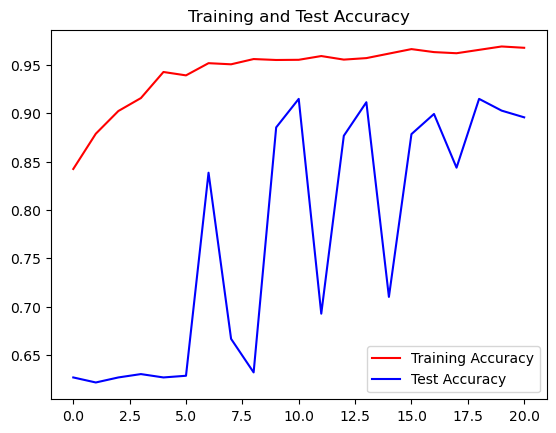

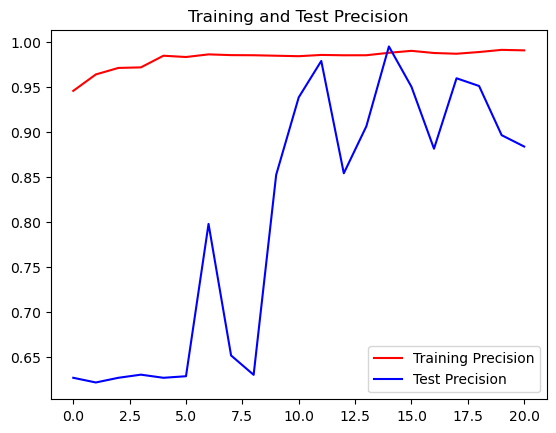

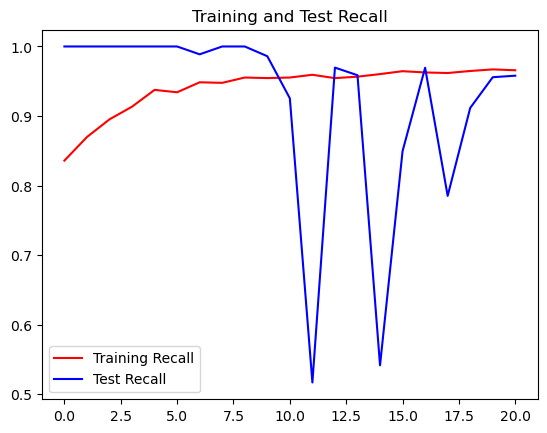

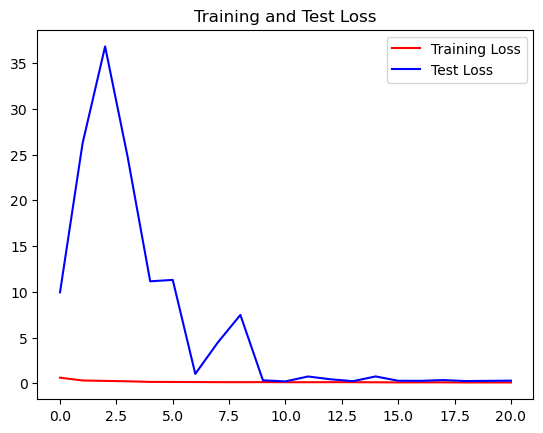

In [70]:
epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Test Precision')
plt.title('Training and Test Precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Test Recall')
plt.title('Training and Test Recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Test Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.show()

Podemos guardar el modelo entrenado en un fichero h5.

In [71]:
classifier.save('chest_xray.h5')

# Hacer nuevas predicciones

Con nuestra red entrenada y validada vamos a clasificar las imágenes de validación que la red no ha visto, para ello leemos las imágenes de la carpeta **val** subfolders **NORMAL** y **PNEUMONIA**, cargamos las imágenes en un array, y los labels reales en otro, para luego de hacer la predicción tener punto de comparación con los labels reales y calcular el accuracy, precision y recall en base a ello, así como mostrar la matriz de confusión.

In [84]:
# To get the data and labels to make prediction on the val set which contains 16 files which the model has not seen before
val_data = []
val_true_labels = []

for item in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(base_dir + 'val' + item)):
        img = image.load_img(base_dir + 'val' + item + img, target_size = (150, 150, 3))
        img = image.img_to_array(img)
        img = img.astype('float32') / 255.
        
        if item == '/NORMAL/':
            label = 0
        elif item == '/PNEUMONIA/':
            label = 1
        val_data.append(img)
        val_true_labels.append(label)
        
val_data = np.array(val_data)
val_true_labels = np.array(val_true_labels)

In [85]:
prediction = classifier.predict(val_data)
tn, fp, fn, tp = confusion_matrix(val_true_labels, np.round(prediction)).ravel()
                                  
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100

print(f'Accuracy: {accuracy_score(val_true_labels, np.round(prediction))*100} %')
print(f'Precision: {precision} %')
print(f'Recall: {recall} %')

1/1 [==============================] - 0s 76ms/step
Accuracy: 87.5 %
Precision: 100.0 %
Recall: 75.0 %


In [86]:
print(classification_report(val_true_labels, np.round(prediction)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



<Figure size 640x480 with 0 Axes>

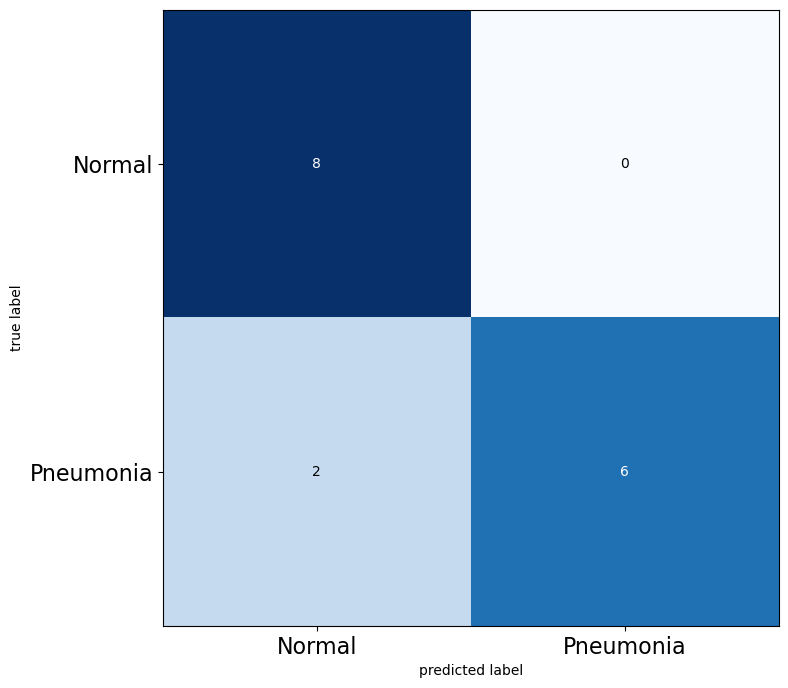

In [83]:
# Get the confusion matrix
cm  = confusion_matrix(val_true_labels, np.round(prediction))
plt.figure()
plot_confusion_matrix(cm,figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Finalmente vemos por la matriz de confusión, que de nuestro conjunto de validación de 16 imágenes, 8 NORMAL y 8 PNEUMONIA, tenemos que la predicción correcta sobre las imágenes normales fue 8/8, y sobre imágenes con neumonía fue 6/8. 